# Step 1.1) Load Libraries¶
Import all necessary libraries for the project.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re  
import numpy as np
from sklearn.ensemble import RandomForestRegressor


# Step 1.2) Load the dataset
Load the dataset and display the first few rows.

In [28]:
df = pd.read_csv("housing.csv")
df.head()
#df.shape

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


In [29]:
### ✅ Step 1: Parse the Address Column
#Your addresses are multi-line strings. We'll break them into: Street,City,State,ZIP Code
# Function to parse city, state, and ZIP from the second line of address
def parse_address(addr):
    # Extract the second line (usually contains city, state ZIP)
    lines = addr.split('\n')
    if len(lines) < 2:
        return pd.Series([None, None, None])
    
    line2 = lines[1]
    
    # Try extracting with regex
    match = re.search(r'(?P<city>.+),\s+(?P<state>[A-Z]{2})\s+(?P<zip>\d{5})', line2)
    if match:
        return pd.Series([match.group('city'), match.group('state'), match.group('zip')])
    else:
        return pd.Series([None, None, None])

df[['City', 'State', 'ZipCode']] = df['Address'].apply(parse_address)
#✅ Step 2: Encode the Categorical Features
#Once extracted City, State, and ZipCode, convert them for modeling:
from sklearn.preprocessing import LabelEncoder

# Encode State and City
le_state = LabelEncoder()
df['State_encoded'] = le_state.fit_transform(df['State'].astype(str))

le_city = LabelEncoder()
df['City_encoded'] = le_city.fit_transform(df['City'].astype(str))

# Optionally convert ZipCode to numeric or categorical:
df['ZipCode'] = df['ZipCode'].astype(str)
df['Zip3'] = df['ZipCode'].str[:3]  # First 3 digits (area code style)
df['Zip3_encoded'] = LabelEncoder().fit_transform(df['Zip3'])


# Step 2.1) Descriptive Statistics
Generate summary statistics for the dataset.

In [30]:
summary = df.describe()
print(summary)
print(df.dtypes)


       Avg. Area Income  Avg. Area House Age  Avg. Area Number of Rooms  \
count       5000.000000          5000.000000                5000.000000   
mean       68583.108984             5.977222                   6.987792   
std        10657.991214             0.991456                   1.005833   
min        17796.631190             2.644304                   3.236194   
25%        61480.562390             5.322283                   6.299250   
50%        68804.286405             5.970429                   7.002902   
75%        75783.338665             6.650808                   7.665871   
max       107701.748400             9.519088                  10.759588   

       Avg. Area Number of Bedrooms  Area Population         Price  \
count                   5000.000000      5000.000000  5.000000e+03   
mean                       3.981330     36163.516039  1.232073e+06   
std                        1.234137      9925.650114  3.531176e+05   
min                        2.000000       17

# Step 2.2) Data Visualizations
Visualize the data to identify patterns and relationships.

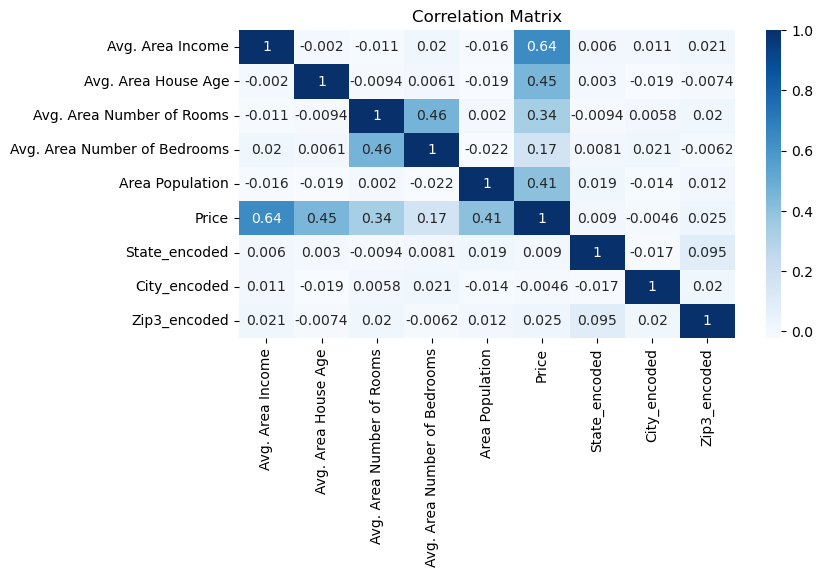

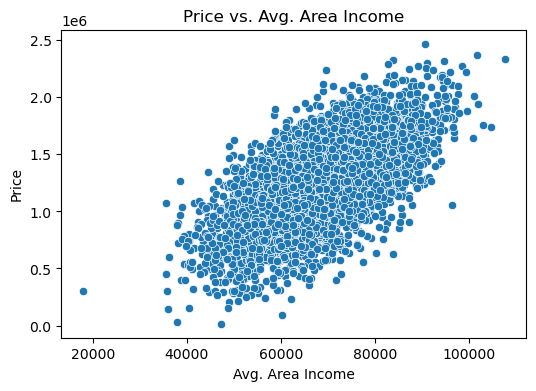

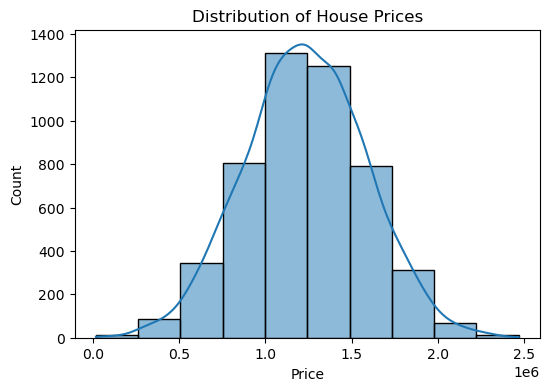

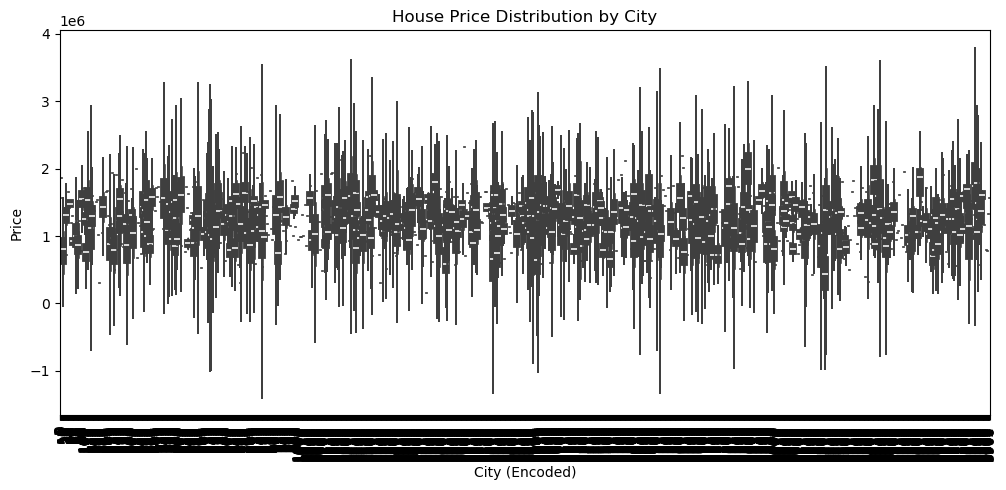

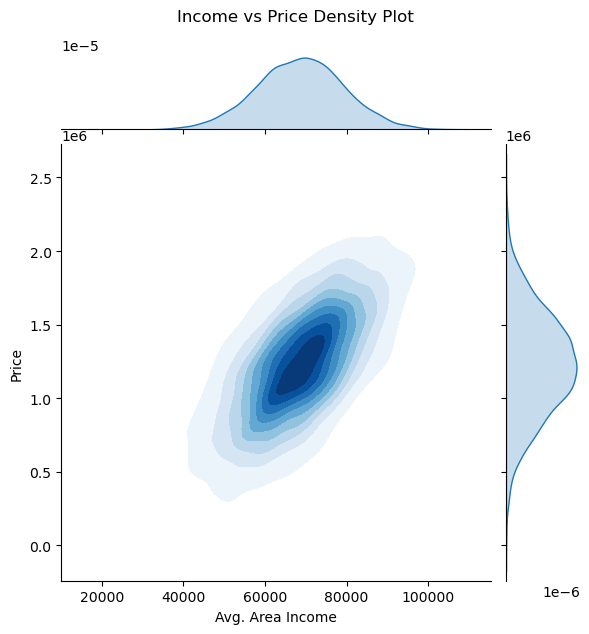

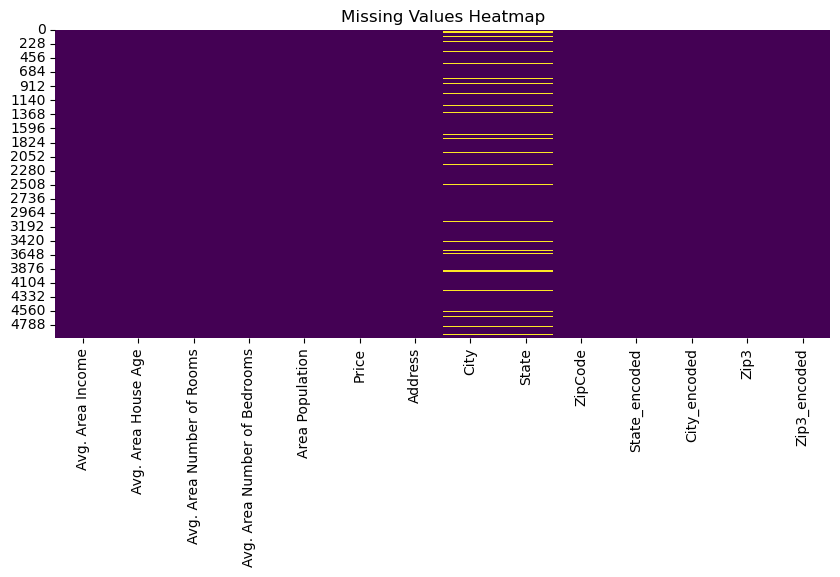

In [31]:

df_numeric = df[[
    'Avg. Area Income',
    'Avg. Area House Age',
    'Avg. Area Number of Rooms',
    'Avg. Area Number of Bedrooms',
    'Area Population',
    'Price',
    'State_encoded',     
    'City_encoded',        
    'Zip3_encoded'          
]]

# Heatmap - 
plt.figure(figsize=(8, 4))
sns.heatmap(df_numeric.corr(), annot=True, cmap='Blues')
plt.title("Correlation Matrix")
plt.show()

# Scatterplot
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Avg. Area Income', y='Price', data=df_numeric)
plt.title("Price vs. Avg. Area Income")
plt.show()

# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(df_numeric['Price'], bins=10, kde=True)
plt.title("Distribution of House Prices")
plt.show()

# Shows price distribution across cities with more detail than boxplot:

plt.figure(figsize=(12, 5))
sns.violinplot(x='City_encoded', y='Price', data=df)
plt.title("House Price Distribution by City")
plt.xlabel("City (Encoded)")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.show()
#Shows scatter + distribution + density contours:

sns.jointplot(x='Avg. Area Income', y='Price', data=df_numeric, kind='kde', fill=True, cmap='Blues')
plt.suptitle("Income vs Price Density Plot", y=1.05)
plt.show()
# If your dataset has missing values, visualize them:
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()




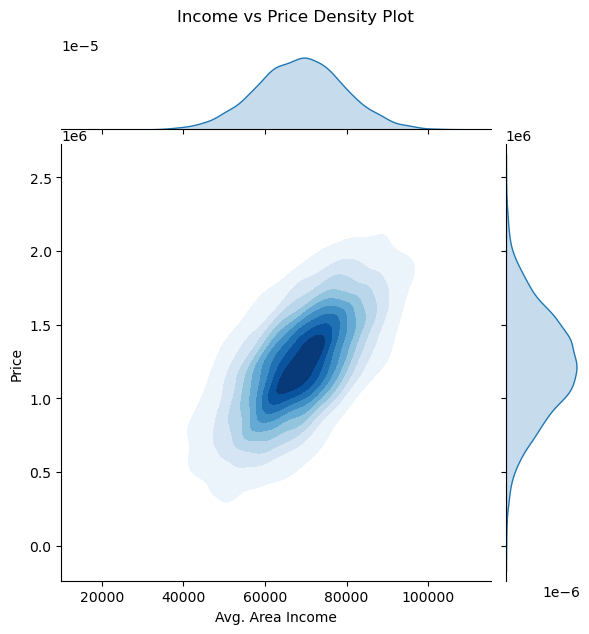

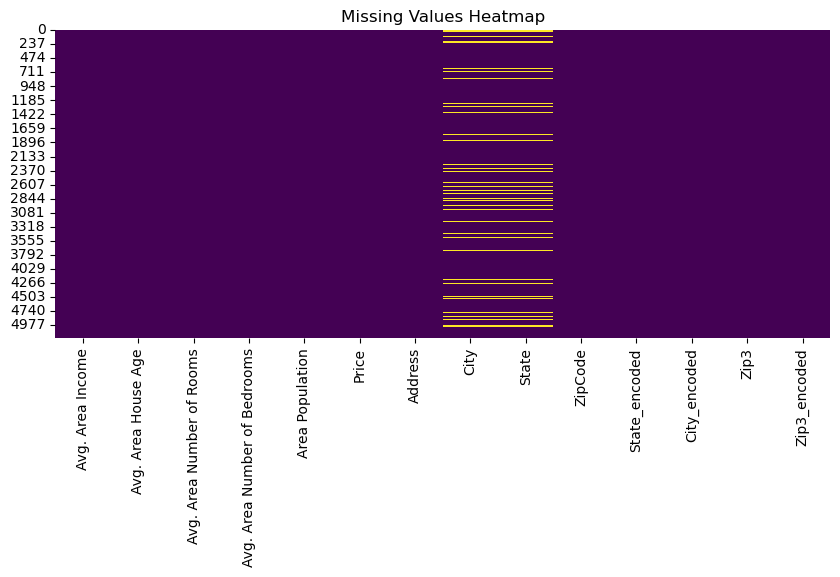

In [37]:
df_numeric = df[[
    'Avg. Area Income',
    'Avg. Area House Age',
    'Avg. Area Number of Rooms',
    'Avg. Area Number of Bedrooms',
    'Area Population',
    'Price',
    'State_encoded',     
    'City_encoded',        
    'Zip3_encoded'          
]]
# Shows price distribution across cities with more detail than boxplot:

#plt.figure(figsize=(12, 5))
#sns.violinplot(x='City_encoded', y='Price', data=df)
#plt.title("House Price Distribution by City")
#plt.xlabel("City (Encoded)")
#plt.ylabel("Price")
#plt.xticks(rotation=90)
#plt.show()
#Shows scatter + distribution + density contours:

sns.jointplot(x='Avg. Area Income', y='Price', data=df_numeric, kind='kde', fill=True, cmap='Blues')
plt.suptitle("Income vs Price Density Plot", y=1.05)
plt.show()
# If your dataset has missing values, visualize them:
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Step 3.1 Clean Data
 Handle Missing Value

In [38]:
df.isnull().sum()


Avg. Area Income                  0
Avg. Area House Age               0
Avg. Area Number of Rooms         0
Avg. Area Number of Bedrooms      0
Area Population                   0
Price                             0
Address                           0
City                            514
State                           514
ZipCode                           0
State_encoded                     0
City_encoded                      0
Zip3                              0
Zip3_encoded                      0
dtype: int64

In [39]:
#Best Idea: Use ZipCode to Fill Missing City and State

#Since each ZipCode is generally tied to a unique City and State, I can use ZipCode to look up the missing values.

In [41]:
# Create reference from non-null rows
zip_to_city_state = df[df['City'].notnull()][['ZipCode', 'City', 'State']].drop_duplicates()
# Merge to fill missing city/state
df = df.merge(zip_to_city_state, on='ZipCode', how='left', suffixes=('', '_ref'))

# Fill only where original is null
df['City'] = df['City'].fillna(df['City_ref'])
df['State'] = df['State'].fillna(df['State_ref'])

# Drop the temporary columns
df.drop(['City_ref', 'State_ref'], axis=1, inplace=True)
#If some ZipCodes don’t help recover City/State, use mode imputation:

df['City'] = df['City'].fillna(df['City'].mode()[0])
df['State'] = df['State'].fillna(df['State'].mode()[0])


In [42]:
df.isnull().sum()


Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
Address                         0
City                            0
State                           0
ZipCode                         0
State_encoded                   0
City_encoded                    0
Zip3                            0
Zip3_encoded                    0
dtype: int64

# Handle Outlier

In [43]:

df_numeric = df.select_dtypes(include=['int64', 'float64']).columns

outlier_summary = {}

for col in df_numeric:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = outliers.shape[0]

    outlier_summary[col] = {
        'Outlier Count': outlier_count,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    }

outlier_df = pd.DataFrame(outlier_summary).T.sort_values(by='Outlier Count', ascending=False)
print(outlier_df)


                              Outlier Count    Lower Bound   Upper Bound
Price                                  71.0  301832.291500  2.153333e+06
Avg. Area Number of Rooms              46.0       4.303896  9.657013e+00
Avg. Area Income                       45.0   39965.806605  9.675382e+04
Area Population                        31.0    9409.211920  6.278573e+04
Avg. Area House Age                    30.0       3.301605  8.705802e+00
Avg. Area Number of Bedrooms           14.0       1.130000  6.490000e+00
State_encoded                           0.0     -29.500000  8.650000e+01
City_encoded                            0.0   -1454.625000  5.370375e+03
Zip3_encoded                            0.0    -542.500000  1.621500e+03


In [44]:
#✅ Recommended Strategy: Capping (Clipping) Outliers
#This keeps the rows but replaces outliers with the nearest valid values. It’s a balanced and safe approach.


In [46]:
# Define the bounds based on your data
outlier_bounds = {
    'Price': (301832.2915, 2153333.0),
    'Avg. Area Number of Rooms': (4.303896, 9.657013),
    'Avg. Area Income': (39965.806605, 96753.82),
    'Area Population': (9409.21192, 62785.73),
    'Avg. Area House Age': (3.301605, 8.705802),
    'Avg. Area Number of Bedrooms': (1.13, 6.49)
}

# Apply clipping
for col, (lower, upper) in outlier_bounds.items():
    df[col] = df[col].clip(lower, upper)


# Step 3.1) Feature Selection¶
Select the most relevant features for the model.

In [49]:
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address,City,State,ZipCode,State_encoded,City_encoded,Zip3,Zip3_encoded
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1059033.558,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701...",Laurabury,NE,37010,34,1607,370,367
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915,"188 Johnson Views Suite 079\nLake Kathleen, CA...",Lake Kathleen,CA,48958,5,1473,489,484
2,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915,"188 Johnson Views Suite 079\nLake Kathleen, CA...",Lake Kathleen,CA,48958,5,1473,489,484
3,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915,"188 Johnson Views Suite 079\nLake Kathleen, CA...",Lake Kathleen,CA,48958,5,1473,489,484
4,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915,"188 Johnson Views Suite 079\nLake Kathleen, CA...",Lake Kathleen,CA,48958,5,1473,489,484


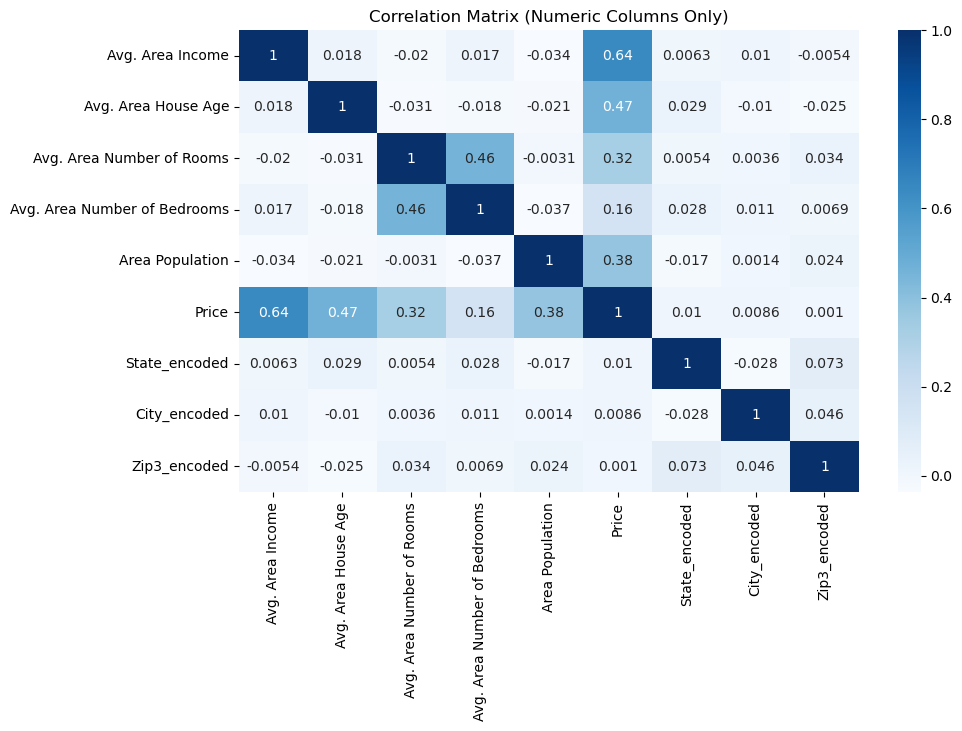


🔍 Pearson Correlation with Price:
Price                           1.000000
Avg. Area Income                0.642454
Avg. Area House Age             0.468749
Area Population                 0.379568
Avg. Area Number of Rooms       0.324278
Avg. Area Number of Bedrooms    0.157377
State_encoded                   0.010008
City_encoded                    0.008625
Zip3_encoded                    0.001008
Name: Price, dtype: float64

🌟 Feature Importance (Random Forest):
                        Feature  Importance
0              Avg. Area Income    0.433966
1           Avg. Area House Age    0.237715
4               Area Population    0.172858
2     Avg. Area Number of Rooms    0.115458
3  Avg. Area Number of Bedrooms    0.011148
6                  City_encoded    0.010618
7                  Zip3_encoded    0.009636
5                 State_encoded    0.008601


/tmp/ipykernel_539502/3654272428.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")


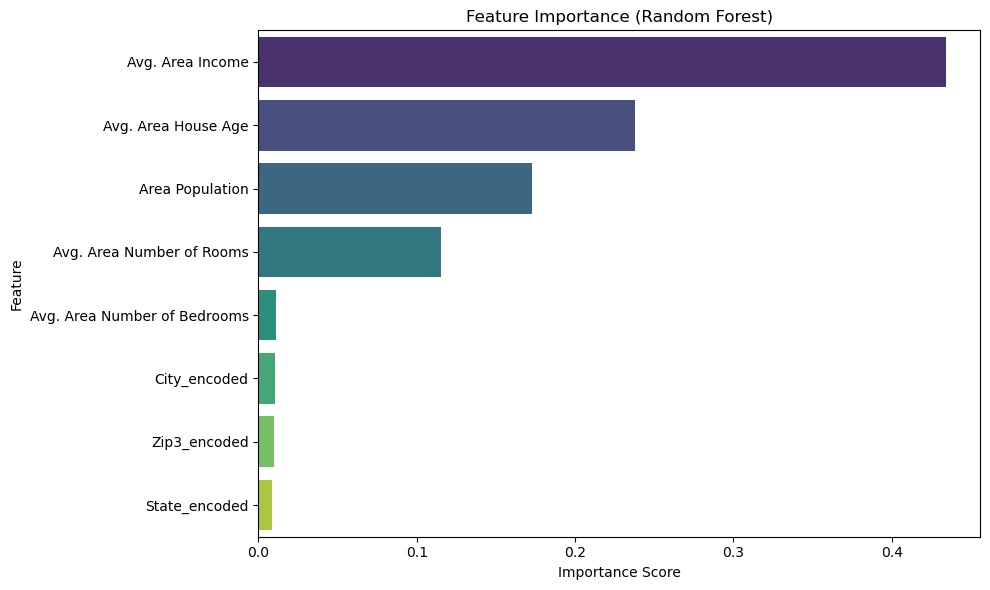

In [53]:

df_numeric = df.select_dtypes(include=['number'])  

correlation = df_numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="Blues")
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()

print("\n🔍 Pearson Correlation with Price:")
print(correlation['Price'].sort_values(ascending=False))


y = df['Price']

X = df.select_dtypes(include=['number']).drop(columns=['Price'])

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🌟 Feature Importance (Random Forest):")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Step Data Transformation

/opt/conda/envs/py39_ml/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


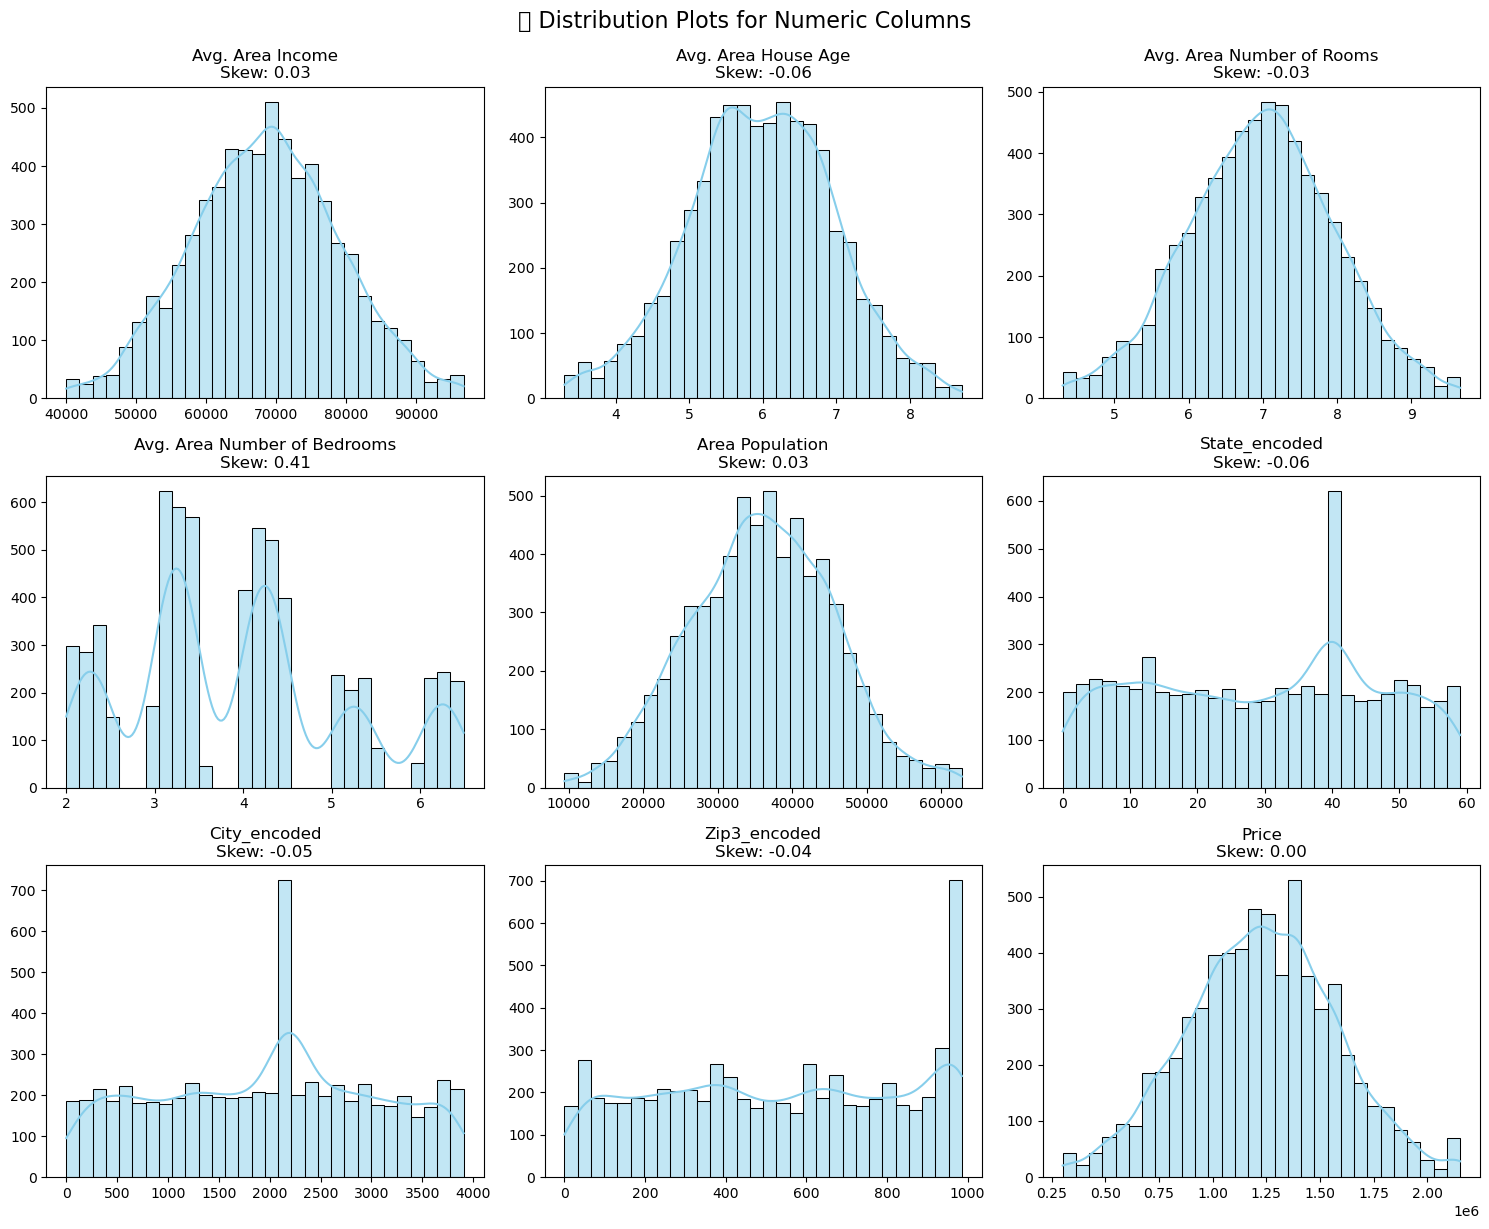

In [57]:

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Price')

numeric_cols = list(numeric_cols) + ['Price']

cols_per_row = 3
total_cols = len(numeric_cols)
rows = int(np.ceil(total_cols / cols_per_row))

plt.figure(figsize=(cols_per_row * 5, rows * 4))

for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"{col}\nSkew: {df[col].skew():.2f}")
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.suptitle("📊 Distribution Plots for Numeric Columns", fontsize=16, y=1.02)
plt.show()


# 4.1) Split-out Validation Dataset
Split the dataset into training and validation sets.

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df.select_dtypes(include=['number']).drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)




# 4.2) Test Options and Evaluation Metric¶
Define the evaluation metric for the model.

In [66]:

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Evaluation Metrics:")
print(f"✅ Mean Squared Error (MSE): {mse:.2f}")
print(f"✅ R-squared (R² Score): {r2:.4f}")


📊 Evaluation Metrics:
✅ Mean Squared Error (MSE): 12187305919.46
✅ R-squared (R² Score): 0.9044


/tmp/ipykernel_539502/1727575355.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/envs/py39_ml/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


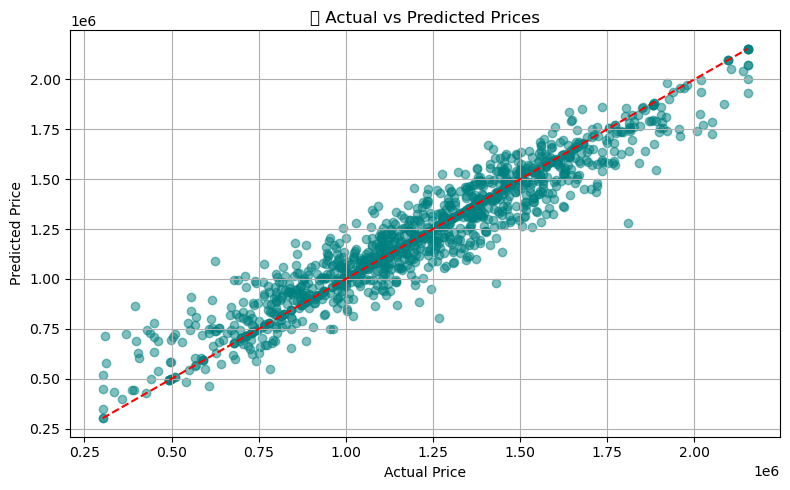

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title("🔍 Actual vs Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()


Baseline MSE: 12187305919.46
Baseline R2: 0.9044
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Tuned MSE: 11969497056.75
Tuned R2: 0.9062


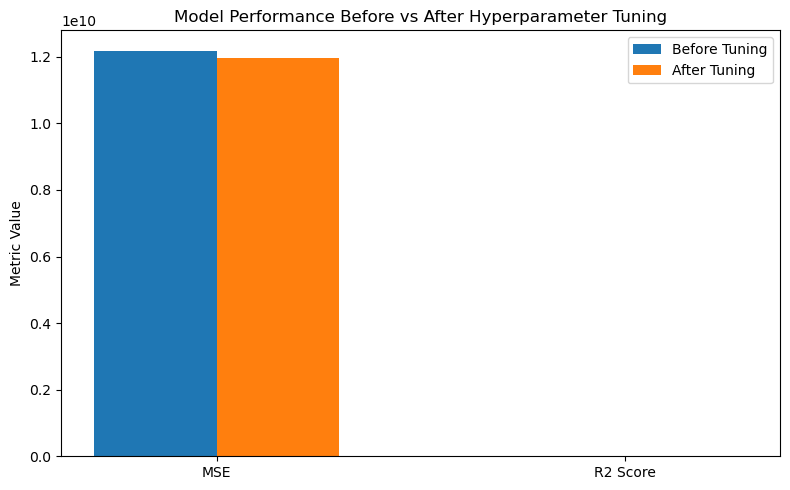

In [67]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# افترض أن X, y مُعرفة مسبقًا (ميزات وهدف)
# إذا لم تقم بتقسيم البيانات بعد:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# نموذج عادي قبل الضبط (Baseline)
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline MSE: {mse_baseline:.2f}")
print(f"Baseline R2: {r2_baseline:.4f}")

# ضبط المعاملات باستخدام GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# أفضل نموذج بعد الضبط
best_model = grid_search.best_estimator_

y_pred_tuned = best_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Tuned MSE: {mse_tuned:.2f}")
print(f"Tuned R2: {r2_tuned:.4f}")

# رسم مقارنة الأداء
metrics = ['MSE', 'R2 Score']
before = [mse_baseline, r2_baseline]
after = [mse_tuned, r2_tuned]

plt.figure(figsize=(8, 5))
x = range(len(metrics))
plt.bar(x, before, width=0.3, label='Before Tuning', align='center')
plt.bar([i + 0.3 for i in x], after, width=0.3, label='After Tuning', align='center')
plt.xticks([i + 0.15 for i in x], metrics)
plt.ylabel("Metric Value")
plt.title("Model Performance Before vs After Hyperparameter Tuning")
plt.legend()
plt.tight_layout()
plt.show()


In [59]:
## In case of using Linear Regresstion Learning Algorithm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# نختار فقط الأعمدة الرقمية (ونستثني السعر لأننا نحاول التنبؤ به)
features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Price'])

# 👇 اختر المحول الذي تريده:
# 1. StandardScaler
scaler = StandardScaler()


# تطبيق التحويل
scaled_array = scaler.fit_transform(features)

# إنشاء DataFrame جديد بالبيانات المقيّسة
df_scaled = pd.DataFrame(scaled_array, columns=features.columns)

# إضافة السعر كما هو (بدون تغيير)
df_scaled['Price'] = df['Price'].values

# ✅ عرض عينة من البيانات بعد التحويل
print(df_scaled.head())


   Avg. Area Income  Avg. Area House Age  Avg. Area Number of Rooms  \
0          1.046857            -0.301493                   0.028055   
1          1.018784             0.022619                  -0.251176   
2          1.018784             0.022619                  -0.251176   
3          1.018784             0.022619                  -0.251176   
4          1.018784             0.022619                  -0.251176   

   Avg. Area Number of Bedrooms  Area Population  State_encoded  City_encoded  \
0                      0.109007        -1.343364       0.256564     -0.341908   
1                     -0.711295         0.430570      -1.434175     -0.466576   
2                     -0.711295         0.430570      -1.434175     -0.466576   
3                     -0.711295         0.430570      -1.434175     -0.466576   
4                     -0.711295         0.430570      -1.434175     -0.466576   

   Zip3_encoded        Price  
0     -0.546303  1059033.558  
1     -0.163040  1505890

📌 Random Forest
  - MSE: 12187305919.46
  - R²: 0.9044
----------------------------------------
📌 Linear Regression (scaled)
  - MSE: 9518323410.04
  - R²: 0.9254
----------------------------------------
